# Imports

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import csv
import winsound

from functions import *
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, PowerTransformer, LabelEncoder, OneHotEncoder
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from scipy.stats import *
from sklearn.inspection import PartialDependenceDisplay

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from tsfresh import extract_features
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.fft import *

%matplotlib notebook
%matplotlib inline
    
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load features

- load_train_meta(vals = False)
- load_features(vals = False)

In [49]:
n = 0

Xmeta = load_train_meta()
Xwave = load_wave_features()

print("Shape of Xmeta:", Xmeta.shape)
print("Shape of Xwave", Xwave.shape)

Shape of Xmeta: (1100, 5)
Shape of Xwave (1100, 170)


## Data Exploration

In [50]:
D = Xmeta['direction']
G = Xmeta['group']
S = Xmeta['speed']
L = Xmeta['label']

- plot_sorted_counts(data, label, xtick=True, rot=90, sorted=True, coloring=None)



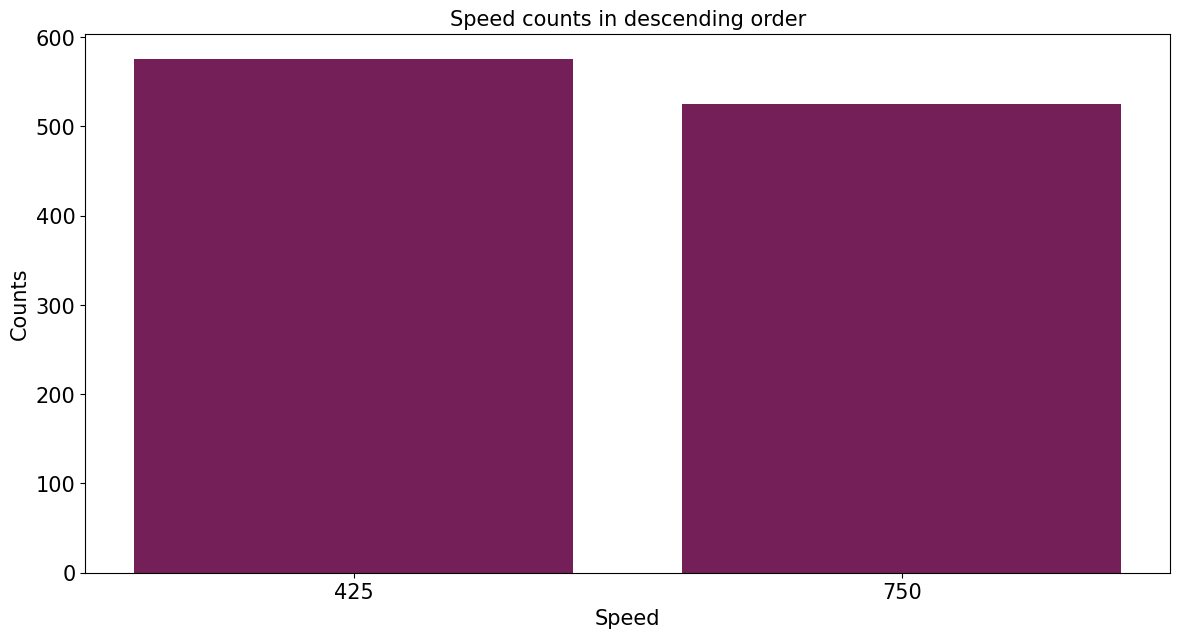

In [124]:
plot_sorted_counts(S, 'Speed', rot = 0)

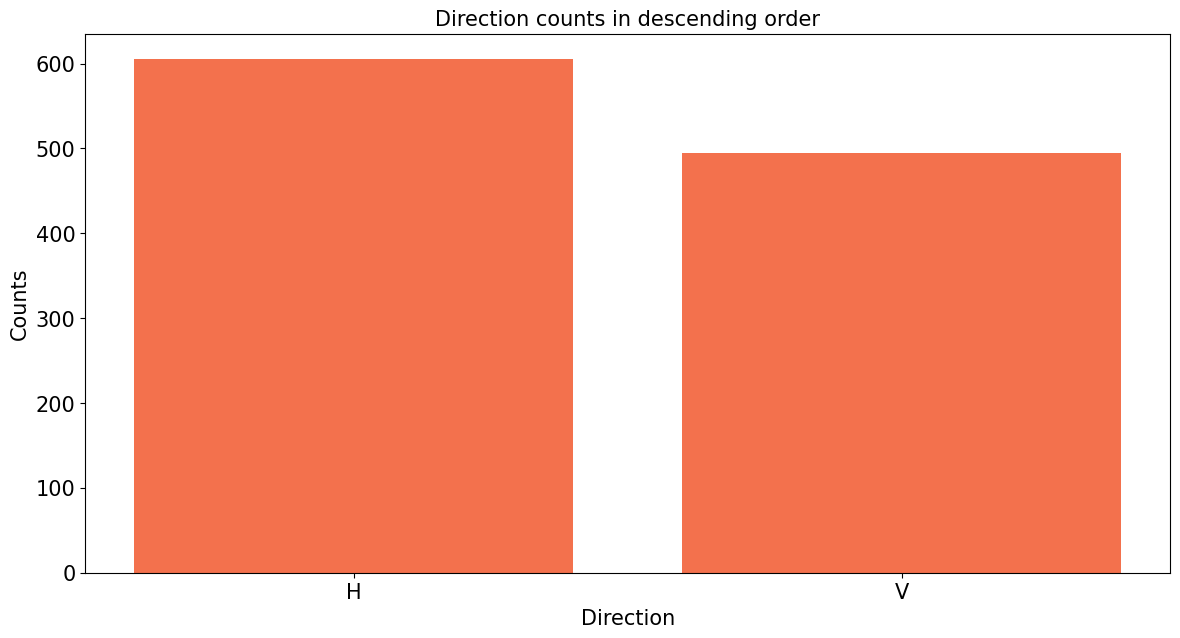

In [125]:
plot_sorted_counts(D, 'Direction', rot = 0)

['-0.5' '-0.4' '-0.3' '-0.2' '-0.1' '0.0' '0.1' '0.2' '0.3' '0.4' '0.5'] [ 95 100  70 105  95 110 130  95  85 115 100]


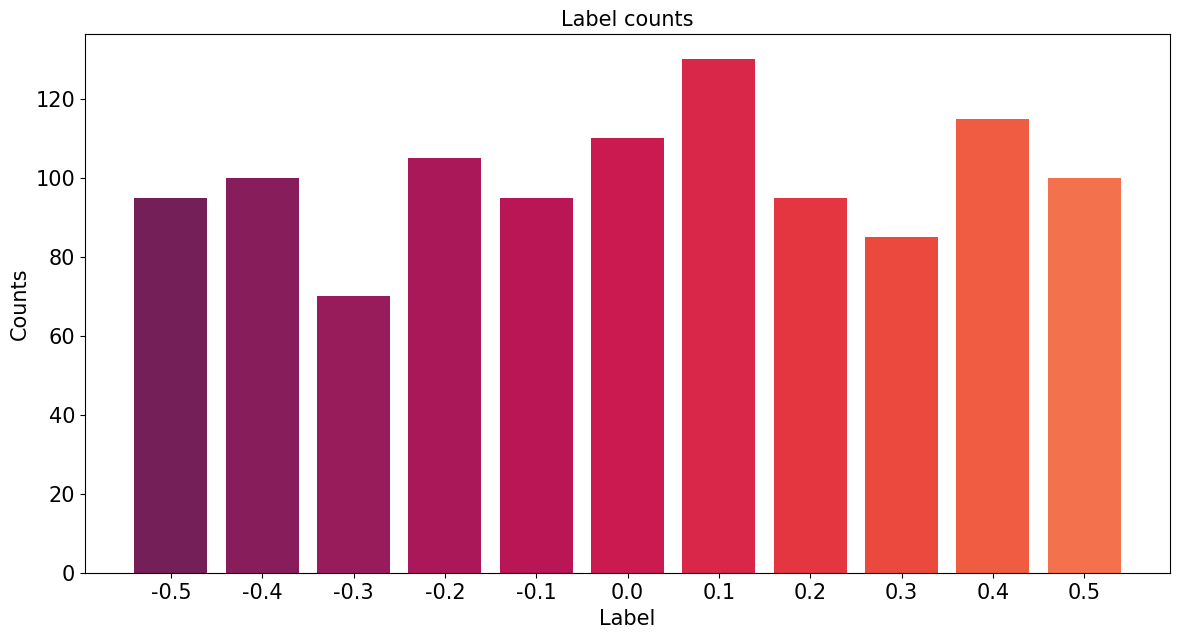

In [85]:
plot_sorted_counts(L, 'Label', rot = 0, sorted=False)

In [103]:
newCols = pd.DataFrame()
str_meta = Xmeta['label'].astype(str)
newCols['OneHotDirGroup'] = str_meta + '_' + Xmeta['direction']

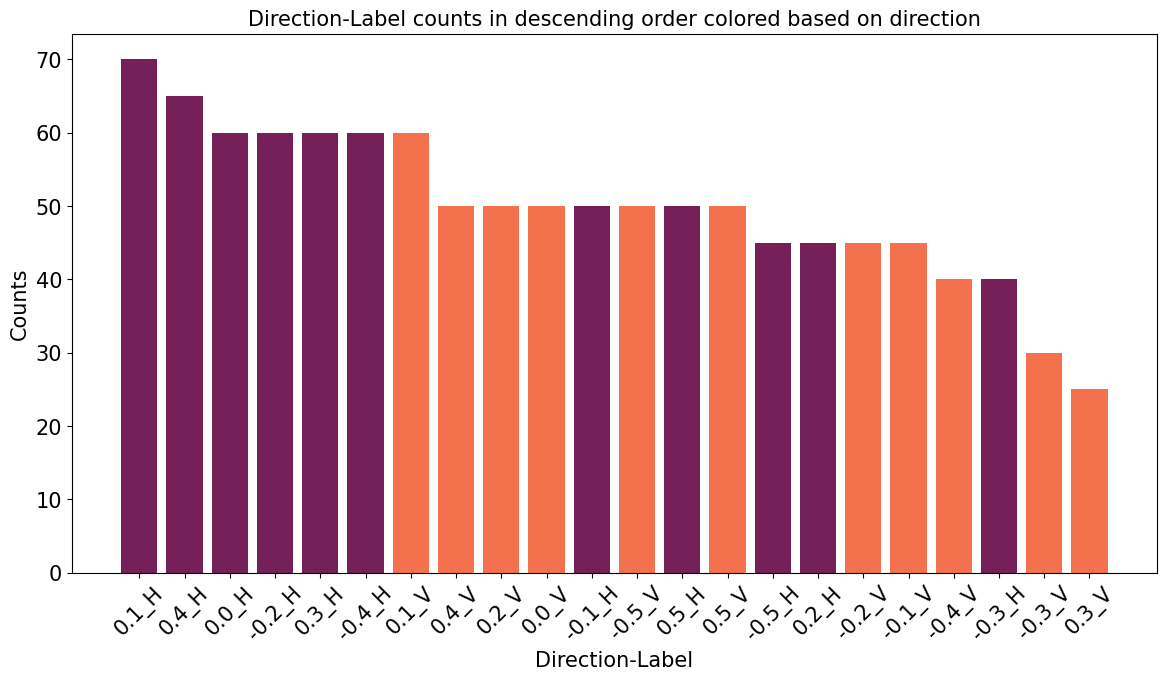

In [105]:
plot_sorted_counts(newCols['OneHotDirGroup'], 'Direction-Label', rot = 45, coloring = 'dir')

In [106]:
newCols['OneHotDirSpeed'] = Xmeta['direction'] + '_' + Xmeta['speed'].apply(lambda x: '425' if x <= 500 else '750')

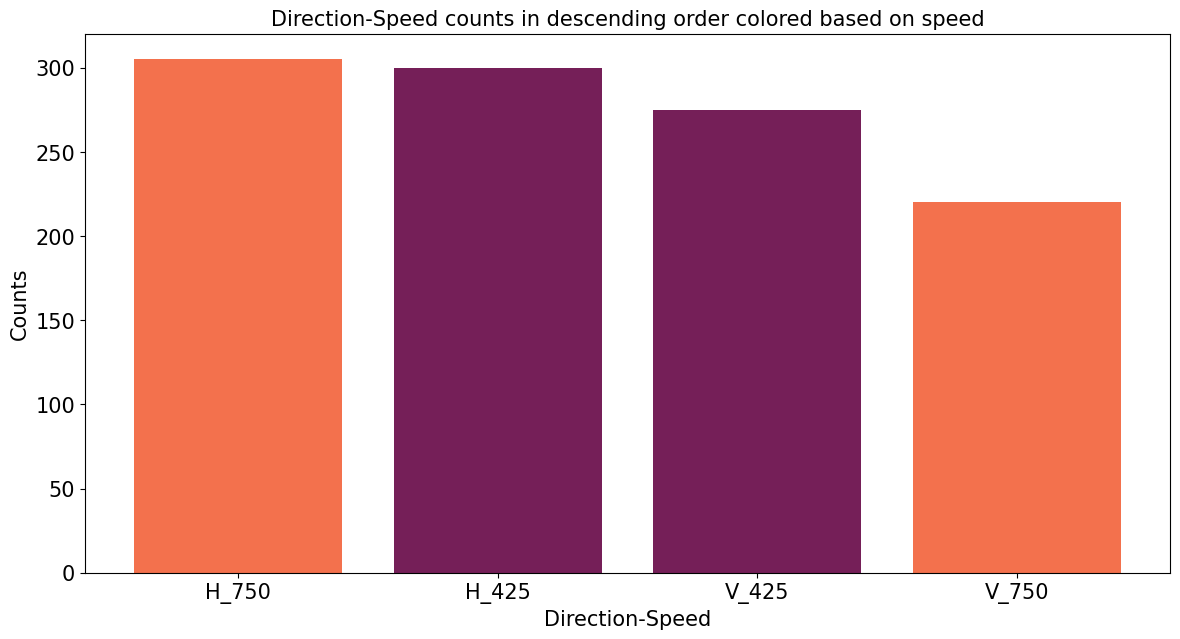

In [107]:
plot_sorted_counts(newCols['OneHotDirSpeed'], 'Direction-Speed', rot = 0, coloring = 'spd')

In [108]:
newCols['OneHotEvr'] = newCols['OneHotDirGroup'] + '_' + Xmeta['speed'].apply(lambda x: '425' if x <= 500 else '750')

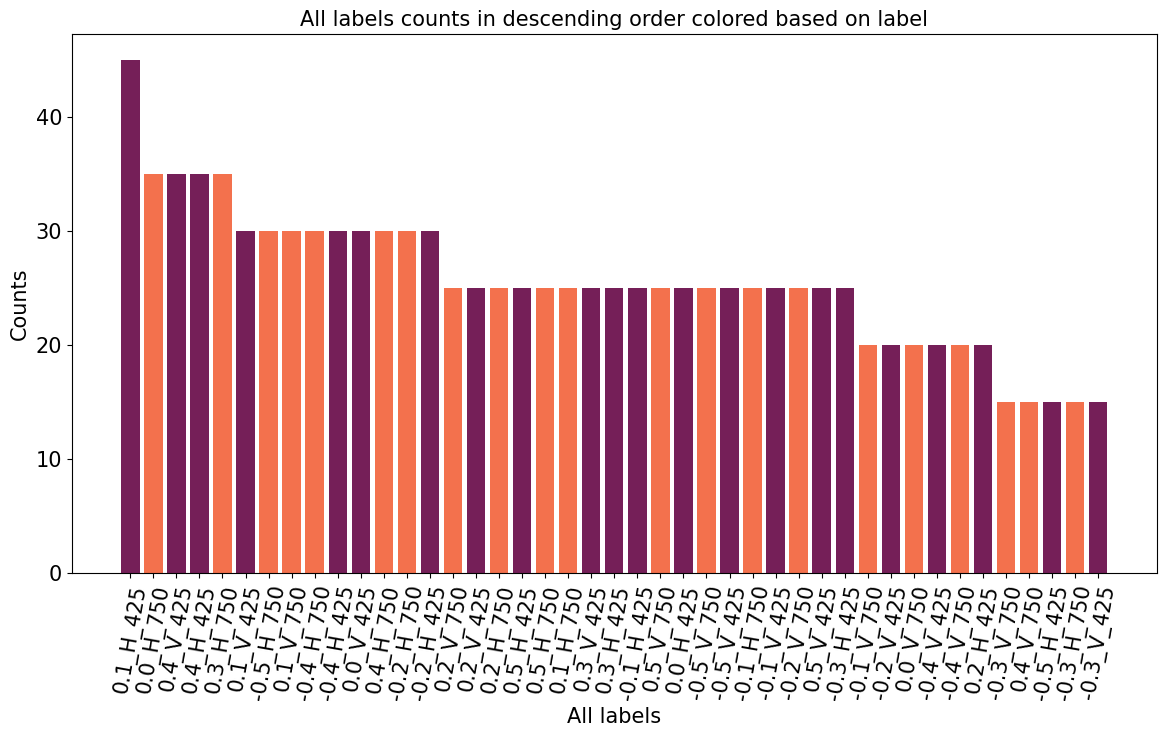

In [116]:
plot_sorted_counts(newCols['OneHotEvr'], 'All labels', rot = 80, sorted = True, coloring = 'grp')

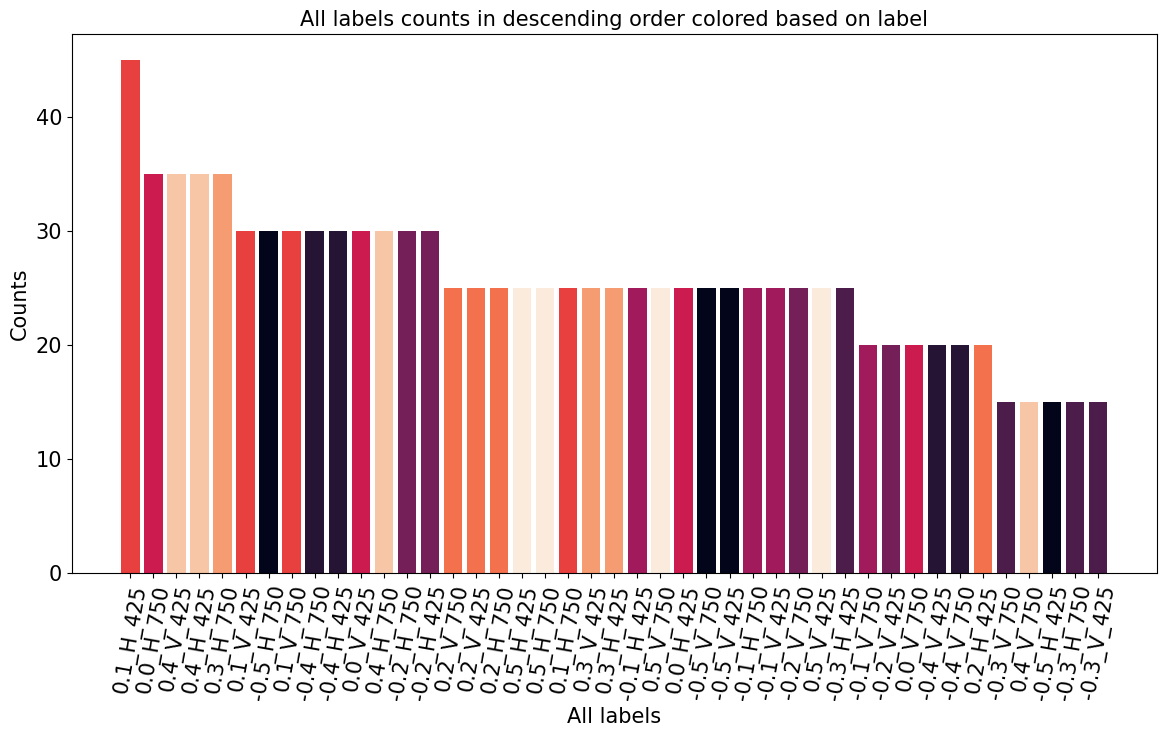

In [123]:
plot_sorted_counts(newCols['OneHotEvr'], 'All labels', rot = 80, sorted = True, coloring = 'grp')

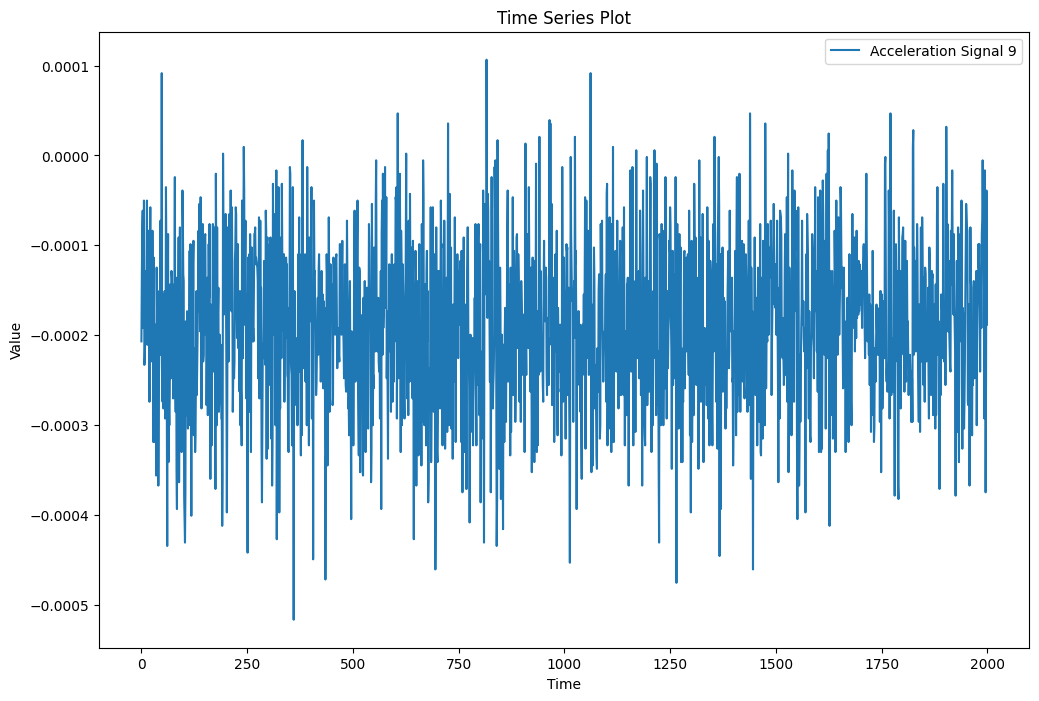

In [80]:
plot_series(9, 10, low = False, high = False, acc = True)

- store_wave_features(store = False)


- get_correlations(X)

In [15]:
# Xwave = load_wave_features()

# get_correlations(Xwave)

In [16]:
# If file does not exist but does not need storing
# extractions = store_wave_features()

# If file does not exist and needs storing
# extractions = store_wave_features(store = True)

In [5]:
from hurst import compute_Hc
import hfda

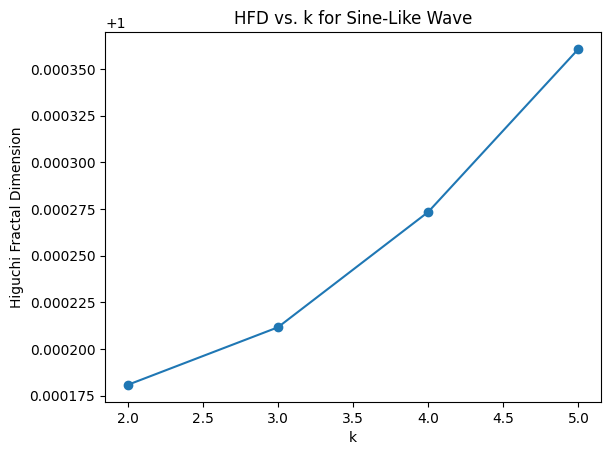

In [77]:
wave = load_features(1000)
low = wave['0']
high = wave['1']
acc = wave['2']

# Experiment with different k values

HFD_values = hfda.measure(high, 8)

# Plot HFD values against k
plt.plot(k_values, HFD_values, marker='o')
plt.xlabel('k')
plt.ylabel('Higuchi Fractal Dimension')
plt.title('HFD vs. k for Sine-Like Wave')
plt.show()

In [6]:
compressed = pd.read_csv('../data/compressed_features.csv').iloc[:,1:]
# compressed

In [6]:
from scipy.fft import *

def get_wave_stats(wave, test=False):

    column_names = ['min_amplitude','max_amplitude', 'mean_aplitude', 'variance', 'stdiv', 'absdev','q_25', 'median_amplitude', 'q_75', 'kurtosis', 'skewness', 'H', 'C', 'rms_amplitude', 'crest_factor']

    if wave < 5:
        column_names += ['entropy']
        
    # Imputer for filling missing (NaN) values with regression
    imputer = IterativeImputer(estimator=Ridge(), random_state=2211595)
    
    # Empty dfs for data accumulation
    compressed_df = pd.DataFrame()
    
    for i in range(1100):
        
        if test:
            X = load_features(i, test=True)
            
        else:
            X = load_features(i)
                
        if wave == 3:
            # If wave index is 3, compute speed
            speed = np.real(integrate.cumulative_trapezoid(X[str(wave-1)], x = X.iloc[:,0]))
            X['3'] = pd.DataFrame(np.transpose(speed))
        
        elif wave == 4:
            # If wave index is 4, compute speed then position
            speed = np.real(integrate.cumulative_trapezoid(X[str(wave-2)], x = X.iloc[:,0]))            
            position = np.real(integrate.cumulative_trapezoid(speed, x = X.iloc[1:,0]))
            
            X['4'] = pd.DataFrame(np.transpose(position))        
        
        elif wave >= 5 and wave < 8:
            # If wave index is greater than or equal to 5, compute the respective rfft of a wave (low, high, acc)
            rft = np.real(fft(X[str(wave-5)].values-np.mean(X[str(wave-5)].values)))
            X[str(wave)] = pd.DataFrame(np.transpose(rft))

        elif wave >= 8:
            phase = np.imag(fft(X[str(wave-8)].values-np.mean(X[str(wave-8)].values)))
            X[str(wave)] = pd.DataFrame(np.transpose(phase))

        # Drop first useless column (Unnamed)
        X = X.drop(X.columns[0], axis=1)

        # Counter to keep track of progress
        if i % 200 == 0:
            p = round(((wave * 1100) + i ) / 8800 * 100)
            print(f'Wave {wave} at index {i} - Progress: {p}%' )

        # Impute missing values by mean
        X.iloc[:, min(wave,3)] = imputer.fit_transform(X.iloc[:, min(wave,3)].values.reshape(-1,1))
        
        # Extract the relevant wave 
        sine_wave = X.iloc[:, min(wave,3)]

        # Extract Compressed features from each wave
        kurt = sine_wave.kurtosis()
        skewness = sine_wave.skew()
        min_amplitude = np.min(sine_wave)
        max_amplitude = np.max(sine_wave)
        mean_amplitude = np.mean(sine_wave)
        variance = np.var(sine_wave)
        stdev = tstd(sine_wave)
        absdev = median_abs_deviation(sine_wave)
        q_25 = sine_wave.quantile(q=0.25)
        median_amplitude = sine_wave.quantile(q=0.5)
        q_75 = sine_wave.quantile(q=0.75)
        rms_amplitude = np.sqrt(np.mean(sine_wave**2))
        crest_factor = max_amplitude / rms_amplitude
        H, C, data = compute_Hc(sine_wave, kind='change', simplified = True)
        HFD = hfda.measure(sine_wave, 8)
        
        # Create list of features to then create a df with the according columns 
        compressed = [min_amplitude, max_amplitude, mean_amplitude, variance, stdev, absdev, q_25, median_amplitude, q_75, kurt, skewness, H, C, rms_amplitude, crest_factor]
        
        if wave < 5:
            entropy = differential_entropy(sine_wave)
            compressed += [entropy]
            
        compressed_features = pd.DataFrame([compressed], columns=[f'{col}' for col in column_names])

        compressed_df = pd.concat([compressed_df, compressed_features], axis = 0)
        
        # Create the histogram of the wave, then create a df with the according columns
        hist, bin_edges = np.histogram(sine_wave, bins=1100)
        hist_features = pd.DataFrame([hist], columns=[f'h{col}' for col in range(len(hist))])
            
        # hist_df = pd.concat([hist_df, hist_features], axis = 0)

    # Concatenate the 2 dataframes into a final feature set for a specific wave     
    wave_df = pd.concat([compressed_df], axis=1)
    
    return wave_df

'''
    store_wave_features(store)

    - store: Stores the obtained wave features in a excel file [boolean - default=False]
'''
def store_wave_features(store = False, test=False):

    waves = ['low', 'high', 'acc', 'speed', 'pos', 'fft_low', 'fft_high', 'fft_acc', 'phase_low','phase_high','phase_acc']
    df = pd.DataFrame()

    for i in range(len(waves)):
        wave_stats = get_wave_stats(i, test=test)

        wave_stats.columns = [waves[i] + '_' + col for col in wave_stats.columns]
        df = pd.concat([df, wave_stats], axis = 1)

    if store and test:
        file_path = '..//data//compressed_test.csv'
        df.to_csv(file_path, index=True, mode='w')

    elif store:
        file_path = '..//data//compressed.csv'
        df.to_csv(file_path, index=True, mode='w')

    print("\n-----Done-----")

    return df
  
store_wave_features(test=False, store=True)

Wave 0 at index 0 - Progress: 0%
Wave 0 at index 200 - Progress: 2%
Wave 0 at index 400 - Progress: 5%
Wave 0 at index 600 - Progress: 7%
Wave 0 at index 800 - Progress: 9%
Wave 0 at index 1000 - Progress: 11%
Wave 1 at index 0 - Progress: 12%
Wave 1 at index 200 - Progress: 15%
Wave 1 at index 400 - Progress: 17%
Wave 1 at index 600 - Progress: 19%
Wave 1 at index 800 - Progress: 22%
Wave 1 at index 1000 - Progress: 24%
Wave 2 at index 0 - Progress: 25%
Wave 2 at index 200 - Progress: 27%
Wave 2 at index 400 - Progress: 30%
Wave 2 at index 600 - Progress: 32%
Wave 2 at index 800 - Progress: 34%
Wave 2 at index 1000 - Progress: 36%
Wave 3 at index 0 - Progress: 38%
Wave 3 at index 200 - Progress: 40%
Wave 3 at index 400 - Progress: 42%
Wave 3 at index 600 - Progress: 44%
Wave 3 at index 800 - Progress: 47%
Wave 3 at index 1000 - Progress: 49%
Wave 4 at index 0 - Progress: 50%
Wave 4 at index 200 - Progress: 52%
Wave 4 at index 400 - Progress: 55%
Wave 4 at index 600 - Progress: 57%
Wav

,low_min_amplitude,low_max_amplitude,low_mean_aplitude,low_variance,low_stdiv,low_absdev,low_q_25,low_median_amplitude,low_q_75,low_kurtosis,...,phase_acc_absdev,phase_acc_q_25,phase_acc_median_amplitude,phase_acc_q_75,phase_acc_kurtosis,phase_acc_skewness,phase_acc_H,phase_acc_C,phase_acc_rms_amplitude,phase_acc_crest_factor
0,-0.031144,0.029510,-0.000221,0.000426,0.020638,0.020646,-0.020619,0.000005,0.020669,-1.436516,...,0.001568,-0.001566,-0.0,0.001566,1.406802,0.0,0.449501,1.924880,0.002783,5.469886
0,-0.029568,0.027844,-0.000383,0.000390,0.019758,0.019881,-0.020138,-0.000111,0.019704,-1.431491,...,0.001679,-0.001678,-0.0,0.001678,47.052243,0.0,0.469840,1.724648,0.003850,13.098514
0,-0.031335,0.029645,-0.000262,0.000433,0.020810,0.020915,-0.020874,0.000007,0.020920,-1.438494,...,0.001654,-0.001654,-0.0,0.001654,0.572010,0.0,0.481533,1.599181,0.002793,3.692932
0,-0.030111,0.028432,-0.000804,0.000410,0.020248,0.020921,-0.021756,-0.000793,0.019992,-1.481125,...,0.001731,-0.001731,-0.0,0.001731,256.392420,0.0,0.632467,0.987094,0.004666,22.485068
0,-0.029545,0.027971,-0.000435,0.000391,0.019781,0.020056,-0.020399,-0.000066,0.019610,-1.445496,...,0.001744,-0.001740,-0.0,0.001740,54.987595,0.0,0.548938,1.232012,0.004438,14.219044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-0.030260,0.028612,-0.000435,0.000408,0.020213,0.020380,-0.020842,-0.000216,0.019979,-1.443405,...,0.001687,-0.001685,-0.0,0.001685,0.416454,0.0,0.486529,1.558728,0.002820,3.358325
0,-0.030257,0.028488,-0.001521,0.000396,0.019914,0.019981,-0.021721,-0.001730,0.018240,-1.433091,...,0.001636,-0.001634,-0.0,0.001634,0.273753,0.0,0.480691,1.493197,0.002662,3.470134
0,-0.029306,0.027739,-0.001282,0.000391,0.019772,0.019933,-0.021382,-0.001637,0.018521,-1.445860,...,0.001775,-0.001774,-0.0,0.001774,74.306656,0.0,0.524544,1.229152,0.004429,14.975466
0,-0.030406,0.028548,-0.000436,0.000409,0.020219,0.020350,-0.020782,-0.000160,0.020001,-1.440456,...,0.001540,-0.001540,-0.0,0.001540,0.634732,0.0,0.619776,1.068818,0.002613,4.200275


In [56]:
df = pd.DataFrame()
from scipy.fft import *
for i in range(1100):

    if (i+1) % 50 == 0:
        p = round((i+1) / 1100 * 100)
        print(f'Index {i} - Progress: {p}%' )

    X = load_features(i,test=True).iloc[:,1:]
    X = X.rename(columns={'0': 'low','1': 'high','2': 'acc',})

    speed = np.real(integrate.cumulative_trapezoid(X['acc'], x = X.iloc[:,0]))
    X['speed'] = pd.DataFrame(np.transpose(speed))
    
    position = np.real(integrate.cumulative_trapezoid(speed, x = X.iloc[1:,0]))
    
    X['pos'] = pd.DataFrame(np.transpose(position)) 
  
    col_names = X.columns

    for j in range(5, 8):
        col = col_names[j-5]
        
        ft = np.real(fft(X[col].values-np.mean(X[col].values)))
        name = 'fft_' + col
        X[name] = pd.DataFrame(np.transpose(ft))

        name = 'phase_' + col
        phase = np.imag(fft(X[col].values-np.mean(X[col].values)))
        X[name] = pd.DataFrame(np.transpose(phase))
    
    col_names = X.columns

    X.fillna(0, inplace=True)

  
    X['id'] = i

    df = pd.concat([df, X])
  
df.reset_index(inplace=True, drop=True)

print(df.shape)

Index 49 - Progress: 5%
Index 99 - Progress: 9%
Index 149 - Progress: 14%
Index 199 - Progress: 18%
Index 249 - Progress: 23%
Index 299 - Progress: 27%
Index 349 - Progress: 32%
Index 399 - Progress: 36%
Index 449 - Progress: 41%
Index 499 - Progress: 45%
Index 549 - Progress: 50%
Index 599 - Progress: 55%
Index 649 - Progress: 59%
Index 699 - Progress: 64%
Index 749 - Progress: 68%
Index 799 - Progress: 73%
Index 849 - Progress: 77%
Index 899 - Progress: 82%
Index 949 - Progress: 86%
Index 999 - Progress: 91%
Index 1049 - Progress: 95%
Index 1099 - Progress: 100%
(2200000, 12)


In [57]:
extracted_features = extract_features(df, column_id='id')

Feature Extraction: 100%|██████████████████████████| 50/50 [1:26:30<00:00, 103.82s/it]


In [58]:
extracted_features.shape

(1100, 8613)

In [59]:
# file_path = '..//data//tsfresh_test.csv'
# extracted_features.to_csv(file_path, index=True, mode='w')

In [177]:
from tsfresh.utilities.dataframe_functions import impute

# features = impute(extracted_features)
features = pd.read_csv('..//data//compressed.csv')
# var_thresh = VarianceThreshold(0.00000001)

# X_selected = pd.DataFrame(var_thresh.fit_transform(features), columns=features.columns[var_thresh.get_support()])
X_selected = features

In [82]:
# file_path = '..//many_features.csv'
# X_selected.to_csv(file_path, index=True, mode='w')

## Visualizing Compressed Features per wave

- analyze(X, features, title, labels, scaler=None)

C:\Users\Khaled\AppData\Local\Temp\ipykernel_13492\2646563150.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_wave = filtered_wave[Xmeta['direction'] == 'V']
C:\Users\Khaled\AppData\Local\Temp\ipykernel_13492\2646563150.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_meta = filtered_meta[Xmeta['direction'] == 'V']


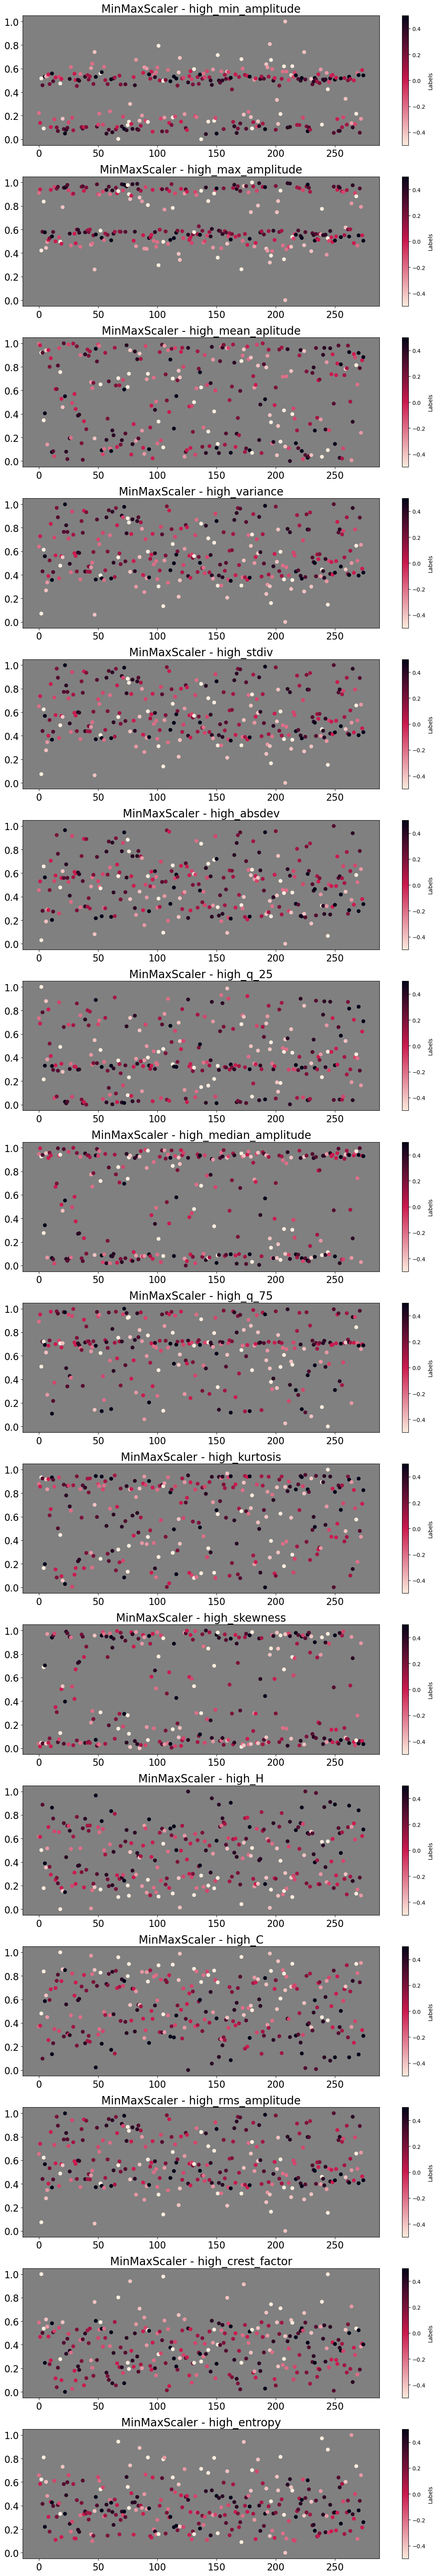

In [149]:
# List of preprocessing techinques

preprocessingList = [MinMaxScaler()]


# Choose which wave and store features (low, high, acc)
wave = 'high'
features = []

filtered_wave = Xwave[Xmeta['speed'] == 425]
filtered_meta = Xmeta[Xmeta['speed'] == 425]

filtered_wave = filtered_wave[Xmeta['direction'] == 'V']
filtered_meta = filtered_meta[Xmeta['direction'] == 'V']

for feature in Xwave.columns:
    if feature.startswith(wave):
        features += [feature]

# Visualize compressed features with preprocessing
for pre in preprocessingList:
    analyze(filtered_wave, features, str(pre)[:-2], filtered_meta['label'], pre)


# Visualize compressed features without any preprocessing (original data)
# analyze(filtered_wave, features, 'Original', filtered_meta['label'])

# Cross Validation

In [307]:
n_folds = 5

#KFold
cv = KFold(n_splits=n_folds, shuffle=True, random_state = 2211597)

# Training

In [308]:
# file_path_comp = '..//data//compressed.csv'
# comp = pd.read_csv(file_path_comp).iloc[:,1:]

file_path_hist = '..//data//histogram.csv'
hist = pd.read_csv(file_path_hist).iloc[:,1:]
# hist = pd.DataFrame(var_thresh.fit_transform(hist), columns=hist.columns[var_thresh.get_support()])


compressed_cols = X_selected.columns
histogram_cols = hist.columns

Xtrain = pd.concat([X_selected, hist], axis = 1)
Ytrain = Xmeta['label']

print('Shape of Xtrain:', Xtrain.shape)
print('Shape of Ytrain:', Ytrain.shape)

Shape of Xtrain: (1100, 12271)
Shape of Ytrain: (1100,)


In [309]:
preprocessing = ColumnTransformer(
    transformers=[
        ('hist_features', Pipeline([('normalizer', Normalizer())]), histogram_cols),
        ('compressed_features', Pipeline([('minmaxscaler', MinMaxScaler())]), compressed_cols),
    ])

# preprocessing =  Pipeline([('normalizer', Normalizer())]) 

feature_selection = Pipeline([('variancethreshold', VarianceThreshold()), ('selectkbest', SelectKBest())]) 

regressor = Pipeline([('reg', SVR())])

In [347]:
# !pip install catboost

param_grid = {
    # 
    #SVR
    'feature_selection__selectkbest__k': [140],
    # 'regressor__reg__alpha': np.logspace(np.log(0.01), np.log(0.1), 10),
    'regressor__reg__C': np.logspace(np.log(17.7), np.log(17.7), 1),
    'regressor__reg__epsilon': np.logspace(np.log(0.1915), np.log(0.1915), 1),
    # 'regressor__reg__kernel': ['rbf'],
        
}
# np.logspace(np.log(17.6), np.log(17.8), 3)
# np.logspace(np.log(0.1905), np.log(0.1915), 3)
np.logspace(np.log(0.1915), np.log(0.1915), 1)

array([0.02223988])

In [348]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('feature_selection', feature_selection),
    ('regressor', regressor)])

gridsearch = GridSearchCV(pipeline, param_grid, n_jobs=6, cv=cv, scoring = mae_scorer, verbose=10, return_train_score=True)
gridsearch.fit(Xtrain, Ytrain)

results = gridsearch.cv_results_

train_score = results['mean_train_score'][gridsearch.best_index_]
validation_score = results['mean_test_score'][gridsearch.best_index_]

print()

print('Best params:')
print(gridsearch.best_params_)

print()

print('Training MAE {}'.format(train_score))
print('Validation MAE: {}'.format(validation_score))

print()

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best params:
{'feature_selection__selectkbest__k': 140, 'regressor__reg__C': 747.4198704909307, 'regressor__reg__epsilon': 0.022239884611411673}

Training MAE -0.11227026064613932
Validation MAE: -0.17212592783232647



In [ ]:
best_estimator = gridsearch.best_estimator_

# Access the SelectKBest transformer
select_k_best = best_estimator.named_steps['feature_selection'][1]

# Get the selected feature indices
selected_indices = select_k_best.get_support()

# # Get the names of selected features
selected_feature_names = [Xtrain.columns[i] for i, selected in enumerate(selected_indices) if selected]

print("Selected feature names:", selected_feature_names)
gridsearch

# Error Analysis

- regression_error_analysis(gridsearch, Xtrain, Ytrain, cv)

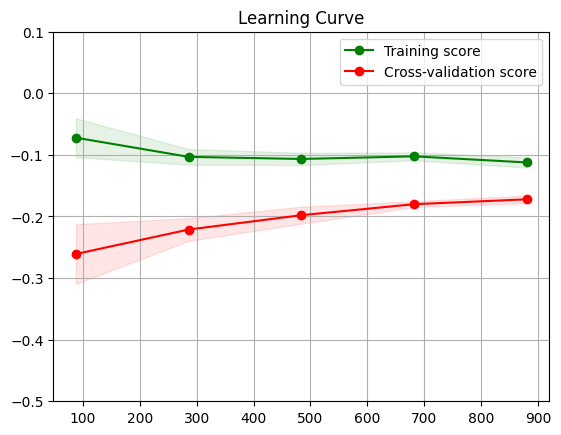

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


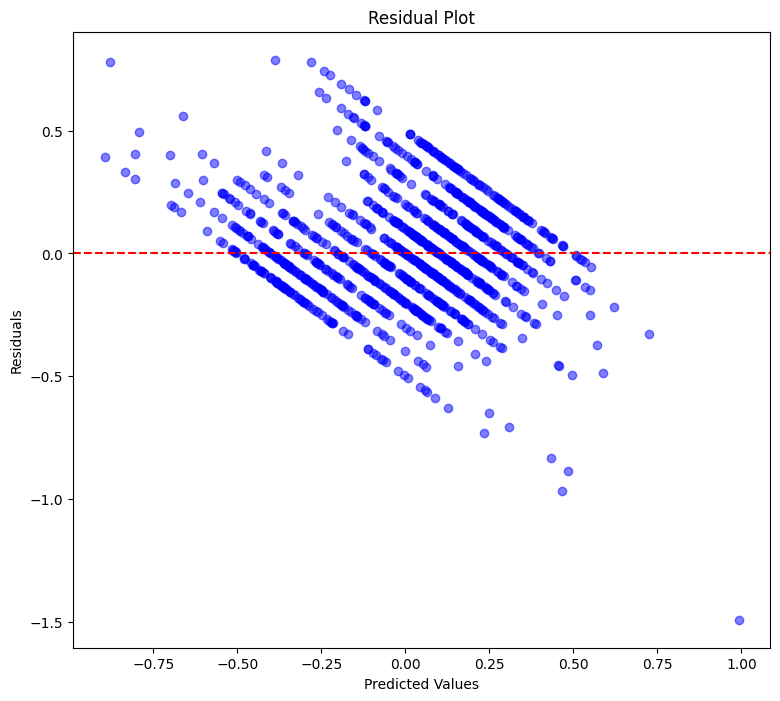

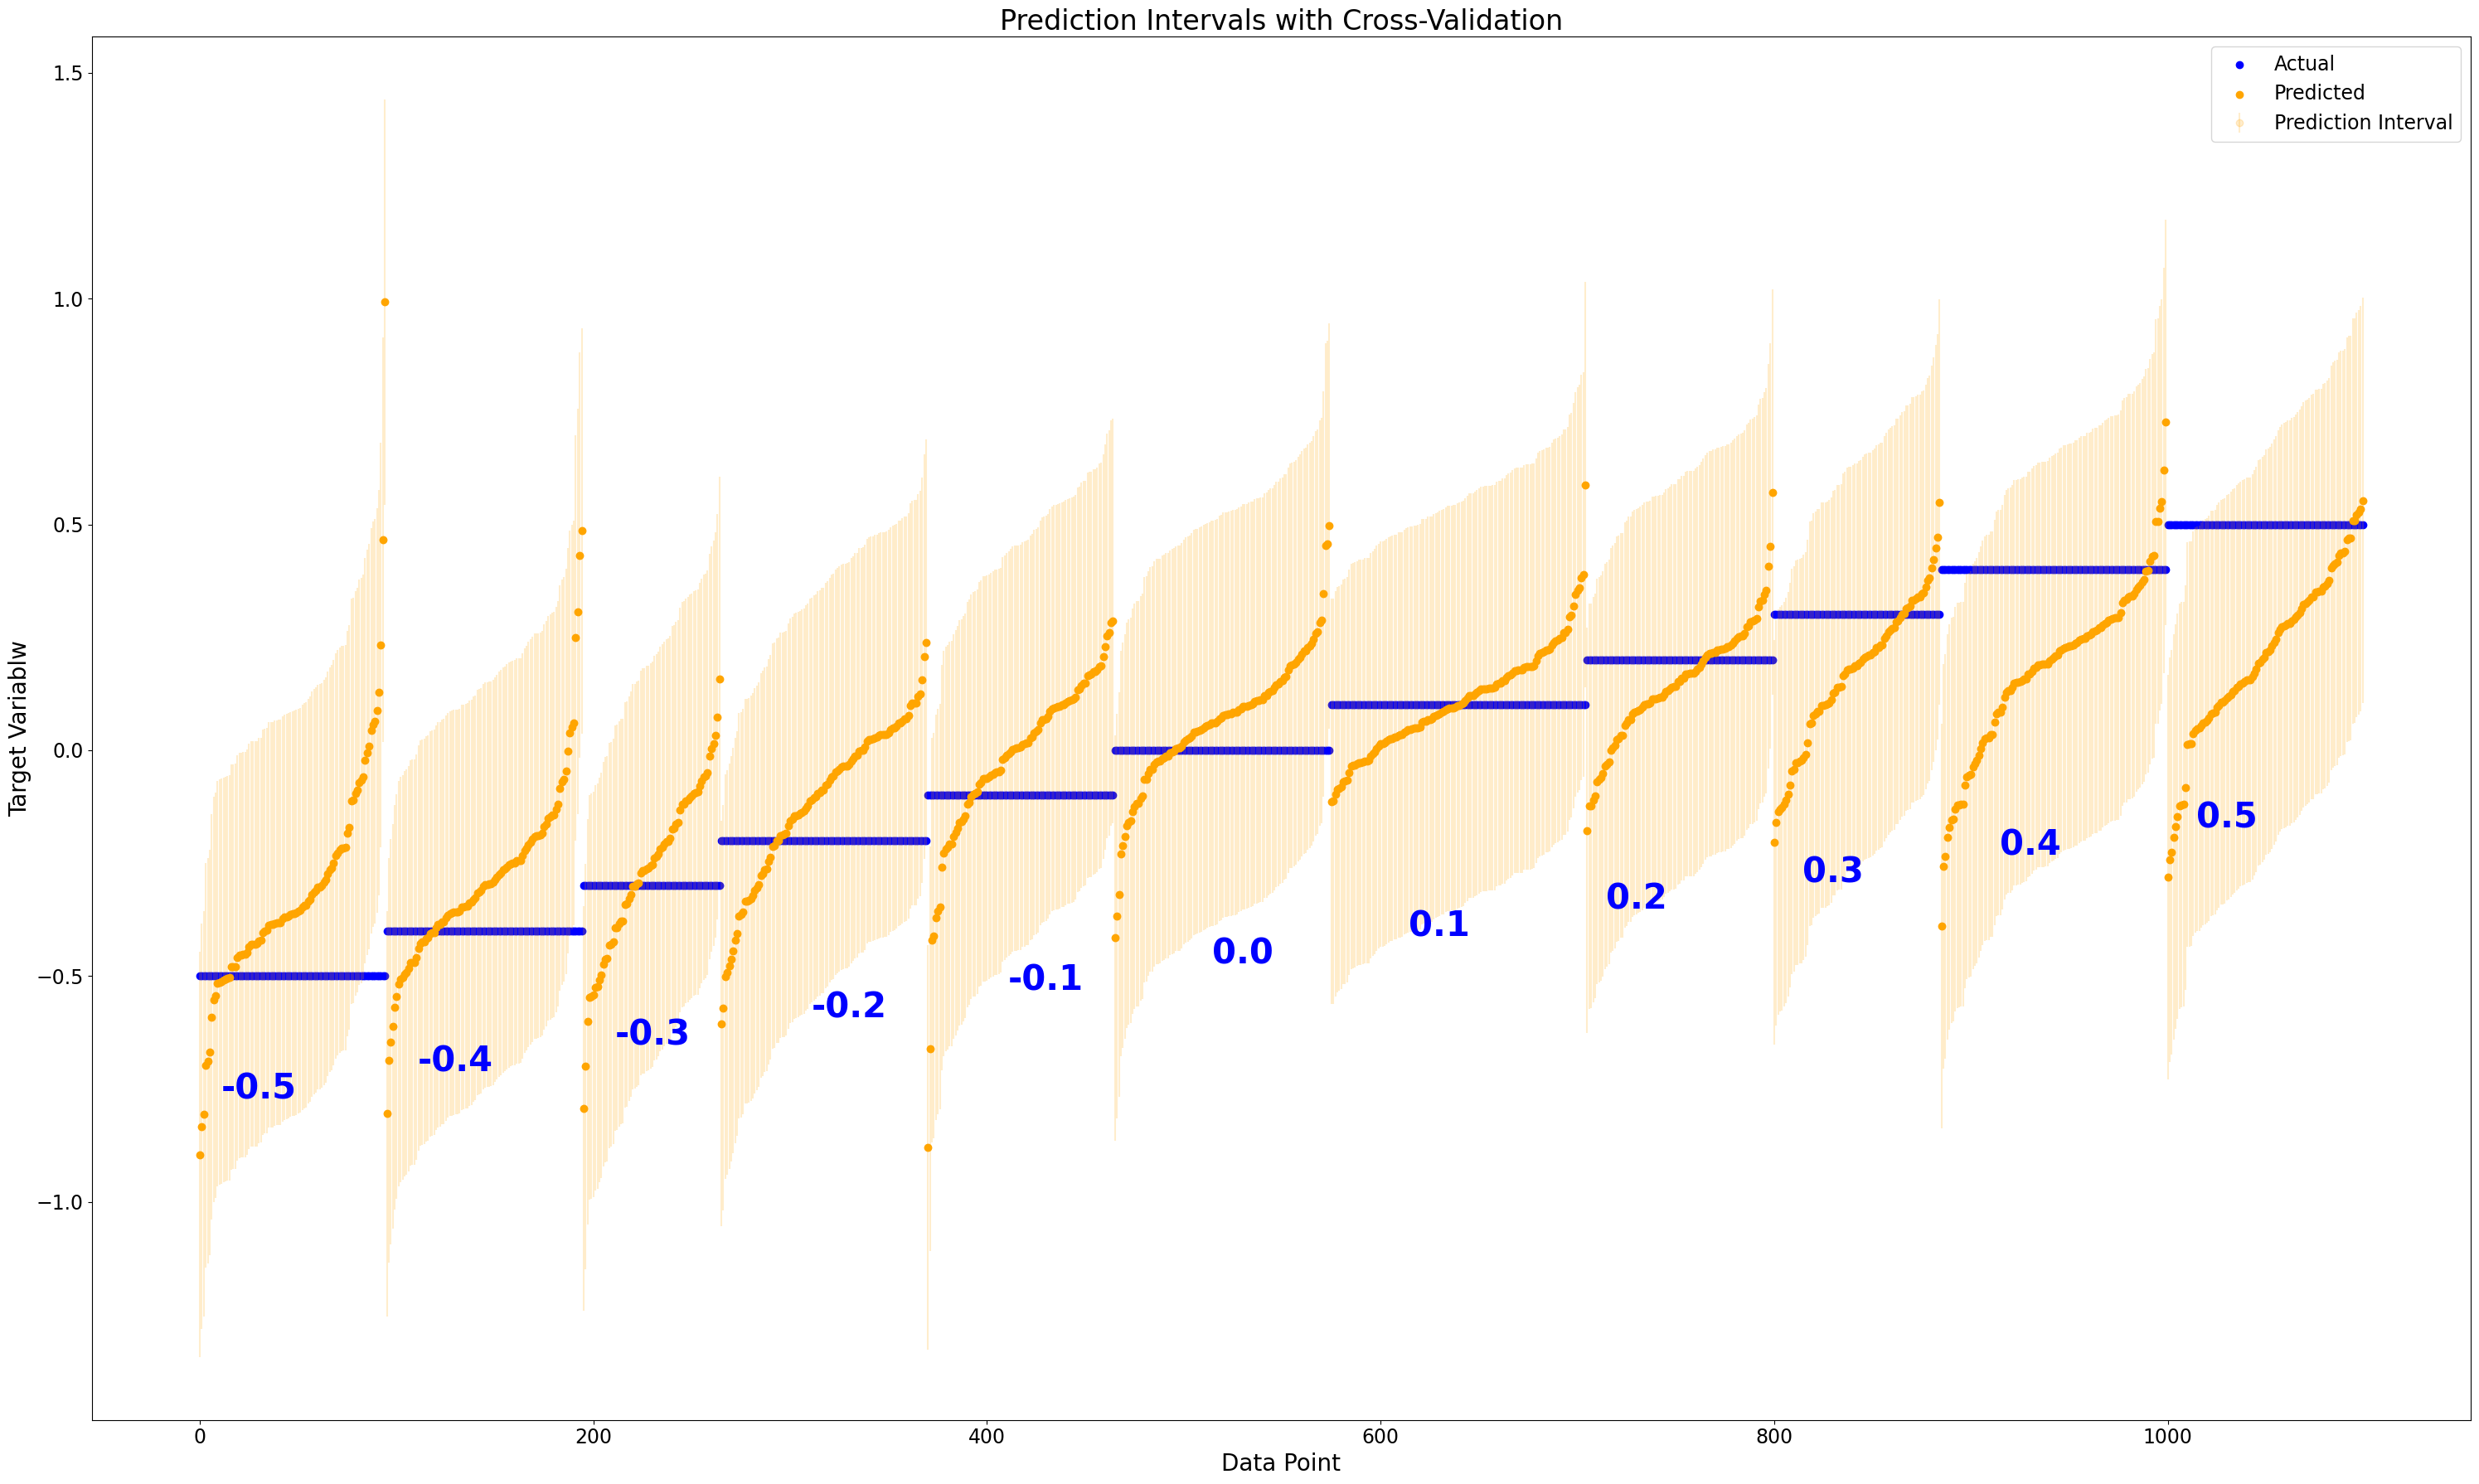

Cross-Validation Mean Absolute Error: 0.1721
Cross-Validation Mean Squared Error: 0.0524
Cross-Validation R-squared: 0.4621


In [349]:
regression_error_analysis(gridsearch, Xtrain, Ytrain, cv)

# Model Prediction

In [ ]:
predict_and_store(best_estimator, store_wave_features)

In [ ]:
def done():
    winsound.Beep(300,200)
    winsound.Beep(400,200)
    winsound.Beep(500,200)
    winsound.Beep(600,200)
    winsound.Beep(400,200)
    winsound.Beep(600,400)

In [ ]:
done()

In [38]:
# file_path_comp = '..//data//compressed_test.csv'
# comp = pd.read_csv(file_path_comp).iloc[:,1:]

# file_path_hist = '..//data//histogram_test.csv'
# hist = pd.read_csv(file_path_hist).iloc[:,1:]


# compressed_cols = comp.columns
# histogram_cols = hist.columns

# Xtest = pd.concat([comp, hist], axis = 1)

# print('Shape of Xtrain:', Xtest.shape)

def predict_and_store(model, Xtest):
        
    # Use the model to make the predictions based on the test data
    Ytest = model.predict(Xtest)
    
    # Create the dataframe and prepare it for submission
    predictions = pd.DataFrame({'misalignment': Ytest})
    predictions['id'] = range(len(predictions))
    predictions = predictions[['id', 'misalignment']]
    predictions['misalignment'] = predictions['misalignment'].astype(float)

    # Name the prediction file with timestamp 
    output_directory = '..//submissions'
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    output_filename = f"output_{timestamp}.csv"
    
    # Store the file in the submission folder
    predictions.to_csv(os.path.join(output_directory, output_filename), index=False)

In [51]:
predict_and_store(gridsearch.best_estimator_, Xtest)